In [1]:
import sklearn
import scipy
print(f"scikit-learn version: {sklearn.__version__}")
print(f"scipy version: {scipy.__version__}")

scikit-learn version: 1.5.2
scipy version: 1.14.1


In [4]:
# import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from tqdm import tqdm

import random

import seaborn as sns
import matplotlib.pyplot as plt


In [5]:
import torch
import torch.nn as nn

class PerCategoryRanking(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_prob=0.5):
        super(PerCategoryRanking, self).__init__()

        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)  # Dropout layer
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)  # Convert input to sparse
        x = self.relu(x)             # ReLU activation
        x = self.dropout(x)          # Apply dropout
        x = self.fc2(x)              # Second fully connected layer
        return x


In [6]:
class PerCategoryRanking2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_prob=0.5):
        super(PerCategoryRanking2, self).__init__()

        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size)  # First fully connected layer
        self.fc2 = nn.Linear(hidden_size, hidden_size) # Second fully connected layer
        self.fc3 = nn.Linear(hidden_size, hidden_size) # Third fully connected layer
        self.fc4 = nn.Linear(hidden_size, num_classes)  # Output layer for ordinal classification

        # Activation function and dropout layers
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = self.fc1(x)            # First fully connected layer
        x = self.relu(x)           # ReLU activation
        x = self.dropout(x)        # Apply dropout

        x = self.fc2(x)            # Second fully connected layer
        x = self.relu(x)           # ReLU activation
        x = self.dropout(x)        # Apply dropout

        x = self.fc3(x)            # Third fully connected layer
        x = self.relu(x)           # ReLU activation
        x = self.dropout(x)        # Apply dropout

        x = self.fc4(x)            # Output layer (raw scores for each class)
        return x

## Prepare Data

In [8]:
movies_df = pd.read_csv("../data/csv/movies.tsv", sep='\t')
users_df = pd.read_csv("../data/csv/users.tsv", sep='\t')
ratings_df = pd.read_csv("../data/csv/ratings_given.csv", sep=',', names=['user_id', 'movie_id', 'rating'])

In [9]:
movies_df.head()

,movie_id,title,year,fantasy,drama,action,horror,musical,crime,children's,...,documentary,thriller,western,sci-fi,romance,mystery,film-noir,adventure,comedy,animation
0,1,Toy Story,1995,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1
1,2,Jumanji,1995,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,3,Grumpier Old Men,1995,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,4,Waiting to Exhale,1995,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,5,Father of the Bride Part II,1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [10]:
movies_df['year'].unique() - movies_df['year'].min()

array([76, 75, 77, 57, 74, 73, 69, 48, 45, 58, 46, 63, 43, 71, 72, 70, 18,
       21, 50, 62, 54, 51, 41, 36, 37, 40, 49, 61, 56, 67, 29, 24, 44, 31,
       27, 68, 78, 55, 39, 30, 53, 79, 14, 33, 32, 38, 42, 35, 15, 25, 23,
       22, 34, 20, 28, 26, 19, 16, 17,  7, 13, 11, 52, 60, 47, 59, 66, 64,
       65, 12,  3,  8, 10,  9,  6,  4, 80,  0, 81,  1,  2])

In [12]:
# # Assuming movies_df is your DataFrame containing the 'year' column
# year_data = np.array(movies_df['year'].unique()).reshape(-1, 1)

# # Initialize the MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0, 1))

# # Fit the scaler and transform the year data
# year_data_normalized = scaler.fit_transform(year_data)

# # Create a dictionary to map the original years to the scaled values
# year_mapping = dict(zip(year_data.flatten(), year_data_normalized.flatten()))

# # Map the scaled values back to the 'year' column in the DataFrame
# movies_df['year_scaled'] = movies_df['year'].map(year_mapping)

# # Print the results
# movies_df[['year', 'year_scaled']]


# Assuming movies_df is your DataFrame containing the 'year' column
# Create a new column 'decade' as explained earlier
movies_df['decade'] = (movies_df['year'] // 10) * 10
movies_df['decade'] = movies_df['decade'].astype(int).astype(str) + "s"

# One-hot encode the 'decade' column
decade_one_hot = pd.get_dummies(movies_df['decade'], prefix='decade')

# Concatenate the one-hot encoded columns back to the original DataFrame
movies_df = pd.concat([movies_df, decade_one_hot], axis=1)

# Print the updated DataFrame
movies_df.head()

,movie_id,title,year,fantasy,drama,action,horror,musical,crime,children's,...,decade_1910s,decade_1920s,decade_1930s,decade_1940s,decade_1950s,decade_1960s,decade_1970s,decade_1980s,decade_1990s,decade_2000s
0,1,Toy Story,1995,0,0,0,0,0,0,1,...,False,False,False,False,False,False,False,False,True,False
1,2,Jumanji,1995,1,0,0,0,0,0,1,...,False,False,False,False,False,False,False,False,True,False
2,3,Grumpier Old Men,1995,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
3,4,Waiting to Exhale,1995,0,1,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
4,5,Father of the Bride Part II,1995,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False


In [23]:
movies_df_encoded = movies_df.drop(columns=['title', 'year', 'decade'])
movies_df_encoded

,movie_id,fantasy,drama,action,horror,musical,crime,children's,war,documentary,...,decade_1910s,decade_1920s,decade_1930s,decade_1940s,decade_1950s,decade_1960s,decade_1970s,decade_1980s,decade_1990s,decade_2000s
0,1,0,0,0,0,0,0,1,0,0,...,False,False,False,False,False,False,False,False,True,False
1,2,1,0,0,0,0,0,1,0,0,...,False,False,False,False,False,False,False,False,True,False
2,3,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
3,4,0,1,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
4,5,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,True
3879,3949,0,1,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,True
3880,3950,0,1,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,True
3881,3951,0,1,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,True


In [24]:
movies_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 39 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   movie_id      3883 non-null   int64
 1   fantasy       3883 non-null   int64
 2   drama         3883 non-null   int64
 3   action        3883 non-null   int64
 4   horror        3883 non-null   int64
 5   musical       3883 non-null   int64
 6   crime         3883 non-null   int64
 7   children's    3883 non-null   int64
 8   war           3883 non-null   int64
 9   documentary   3883 non-null   int64
 10  thriller      3883 non-null   int64
 11  western       3883 non-null   int64
 12  sci-fi        3883 non-null   int64
 13  romance       3883 non-null   int64
 14  mystery       3883 non-null   int64
 15  film-noir     3883 non-null   int64
 16  adventure     3883 non-null   int64
 17  comedy        3883 non-null   int64
 18  animation     3883 non-null   int64
 19  decade_1910s  3883 non-null

In [25]:
users_df.head()

,user_id,gender,age_group,region,address
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [26]:
# Perform one-hot encoding on the categorical columns
users_df_encoded = pd.get_dummies(users_df.drop(columns=['address']), columns=['gender', 'age_group', 'region'])

# Display the encoded DataFrame
users_df_encoded.head()

,user_id,gender_F,gender_M,age_group_1,age_group_18,age_group_25,age_group_35,age_group_45,age_group_50,age_group_56,...,region_11,region_12,region_13,region_14,region_15,region_16,region_17,region_18,region_19,region_20
0,1,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2,False,True,False,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
2,3,False,True,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,4,False,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,5,False,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [27]:
users_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   user_id       6040 non-null   int64
 1   gender_F      6040 non-null   bool 
 2   gender_M      6040 non-null   bool 
 3   age_group_1   6040 non-null   bool 
 4   age_group_18  6040 non-null   bool 
 5   age_group_25  6040 non-null   bool 
 6   age_group_35  6040 non-null   bool 
 7   age_group_45  6040 non-null   bool 
 8   age_group_50  6040 non-null   bool 
 9   age_group_56  6040 non-null   bool 
 10  region_0      6040 non-null   bool 
 11  region_1      6040 non-null   bool 
 12  region_2      6040 non-null   bool 
 13  region_3      6040 non-null   bool 
 14  region_4      6040 non-null   bool 
 15  region_5      6040 non-null   bool 
 16  region_6      6040 non-null   bool 
 17  region_7      6040 non-null   bool 
 18  region_8      6040 non-null   bool 
 19  region_9      6040 non-null

In [28]:
ratings_df.head()

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [29]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800168 entries, 0 to 800167
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   user_id   800168 non-null  int64
 1   movie_id  800168 non-null  int64
 2   rating    800168 non-null  int64
dtypes: int64(3)
memory usage: 18.3 MB


In [30]:
# Merge ratings_df with users_df_encoded on user_id to add user features
ratings_with_user_features = pd.merge(ratings_df, users_df_encoded, on='user_id', how='left')

# Merge the resulting DataFrame with movies_df_encoded on movie_id to add movie features
ratings_with_all_features = pd.merge(ratings_with_user_features, movies_df_encoded, on='movie_id', how='left')

# Display the resulting DataFrame
ratings_with_all_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800168 entries, 0 to 800167
Data columns (total 71 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   user_id       800168 non-null  int64
 1   movie_id      800168 non-null  int64
 2   rating        800168 non-null  int64
 3   gender_F      800168 non-null  bool 
 4   gender_M      800168 non-null  bool 
 5   age_group_1   800168 non-null  bool 
 6   age_group_18  800168 non-null  bool 
 7   age_group_25  800168 non-null  bool 
 8   age_group_35  800168 non-null  bool 
 9   age_group_45  800168 non-null  bool 
 10  age_group_50  800168 non-null  bool 
 11  age_group_56  800168 non-null  bool 
 12  region_0      800168 non-null  bool 
 13  region_1      800168 non-null  bool 
 14  region_2      800168 non-null  bool 
 15  region_3      800168 non-null  bool 
 16  region_4      800168 non-null  bool 
 17  region_5      800168 non-null  bool 
 18  region_6      800168 non-null  bool 
 19  re

## Training and Validation

In [81]:
# Drop user_id and movie_id, as they are not needed
from sklearn.preprocessing import MinMaxScaler


X = ratings_with_all_features.drop(columns=['user_id', 'movie_id', 'rating'])
X = X.astype(np.float32)

# Set the target variable (rating)
y = ratings_with_all_features['rating'].astype(np.float32)

# Convert the features (X) and target (y) to NumPy arrays
X = X.values
y = y.values

# Convert to trinary target
# Class 0: y <= 3, Class 1: y == 4, Class 2: y == 5
# y = np.where(y <= 3, 0, np.where(y == 4, 1, 2))  # Assign classes based on conditions
# y = y.astype(np.int64)  # Ensure integer type for classification

# y = (y - y.mean())/(y.max() - y.mean())
scaler = MinMaxScaler(feature_range=(-1, 1))
y = scaler.fit_transform(y.reshape(-1, 1)).squeeze()#(y - y.min())/(y.max() - y.min()) * (y.max() - y.min()) + y.min() # min max scaling

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)  # Use torch.long for classification targets

In [82]:
y_tensor.shape

torch.Size([800168])

In [83]:
# Split the dataset into 80% training and 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.05, random_state=42)

# Create TensorDatasets for training and validation
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

In [ ]:
# class MovieDataset(Dataset):
#     def __init__(self, features, target):
#         self.features = features
#         self.target = target

#     def __len__(self):
#         return len(self.features)

#     def __getitem__(self, idx):
#         # Return the features and target at index 'idx'
#         return self.features[idx], self.target[idx]


In [ ]:
# # Create an instance of the dataset
# dataset = MovieDataset(X_tensor, y_tensor)

# # Create a DataLoader instance for batching and shuffling
# batch_size = 256
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [84]:
# Create DataLoader instances for batching and shuffling (for training set) and without shuffling (for validation set)
batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Example: Checking the first batch of training data
for inputs, targets in train_dataloader:
    print(f"Inputs shape: {inputs.shape}, Targets shape: {targets.shape}")
    break

Inputs shape: torch.Size([256, 68]), Targets shape: torch.Size([256])


In [ ]:
# from torch.utils.data import WeightedRandomSampler

# # Compute the class weights based on the class distribution in y_tensor
# class_counts = torch.bincount(y_train)
# class_weights = 1. / class_counts.float()
# sample_weights = class_weights[y_train]

# # Create a WeightedRandomSampler
# sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)

RuntimeError: "bincount_cpu" not implemented for 'Float'

In [69]:
X.shape[1]

68

In [94]:
input_size = X.shape[1]    # Input feature size
hidden_size = 256   # Hidden layer size
output_size = 1    # Output size (e.g., regression task or binary classification)
dropout_prob = 0.5 # Probability of dropout
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the model
model = PerCategoryRanking2(input_size, hidden_size, output_size, dropout_prob).to(device)


# Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss() # Ordinal classification
criterion = nn.L1Loss() # Regression
# Calculate class weights based on the frequency of each class

optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.001)

Training Epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

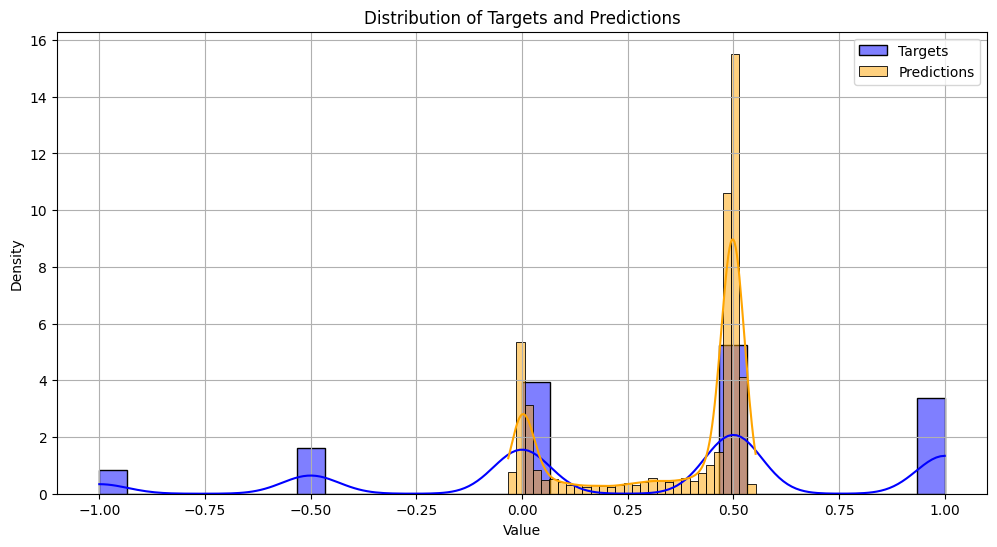

Training Epochs:  10%|█         | 1/10 [00:18<02:48, 18.67s/epoch]

Epoch [1/10], Training Loss: 0.4300, Validation Loss: 0.4183


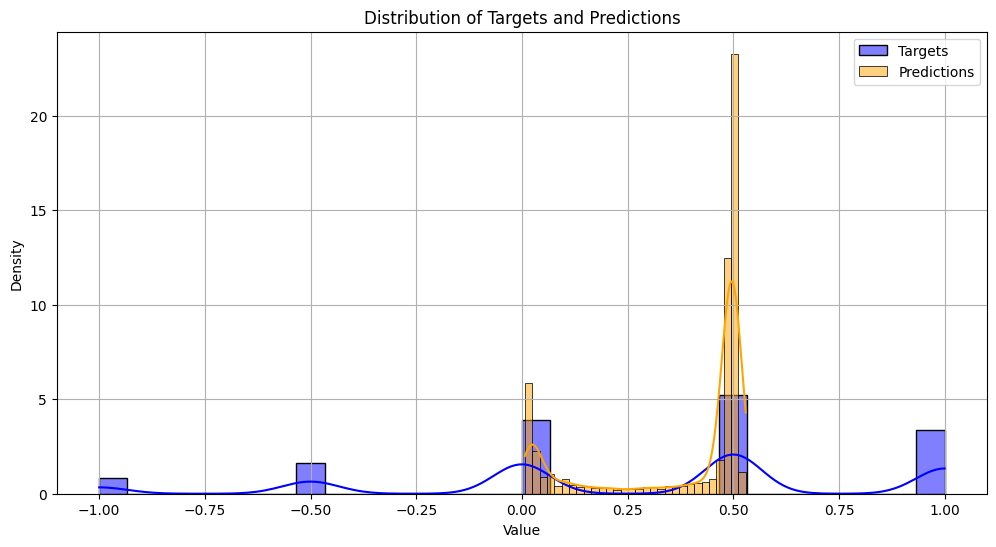

Training Epochs:  20%|██        | 2/10 [00:37<02:32, 19.02s/epoch]

Epoch [2/10], Training Loss: 0.4227, Validation Loss: 0.4180


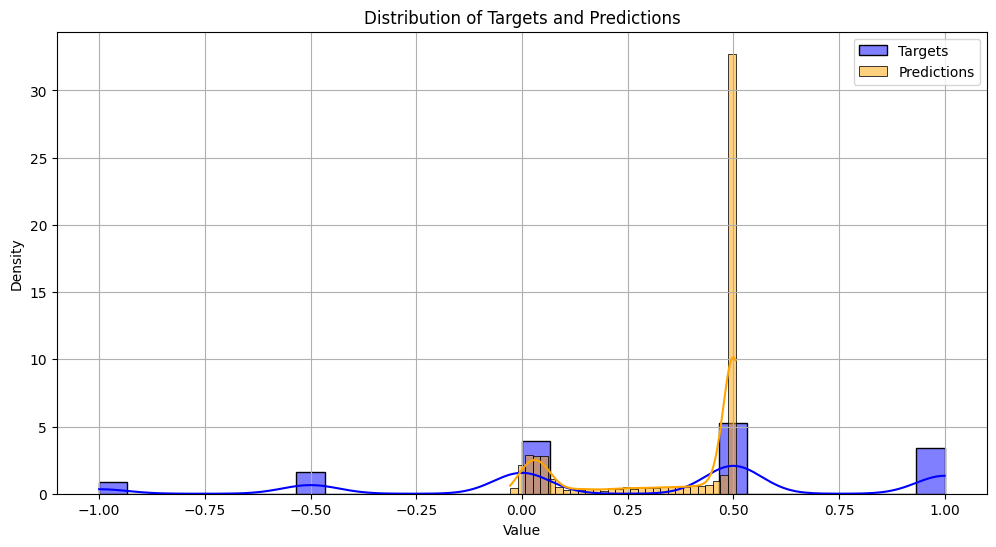

Training Epochs:  30%|███       | 3/10 [00:58<02:19, 19.87s/epoch]

Epoch [3/10], Training Loss: 0.4204, Validation Loss: 0.4158


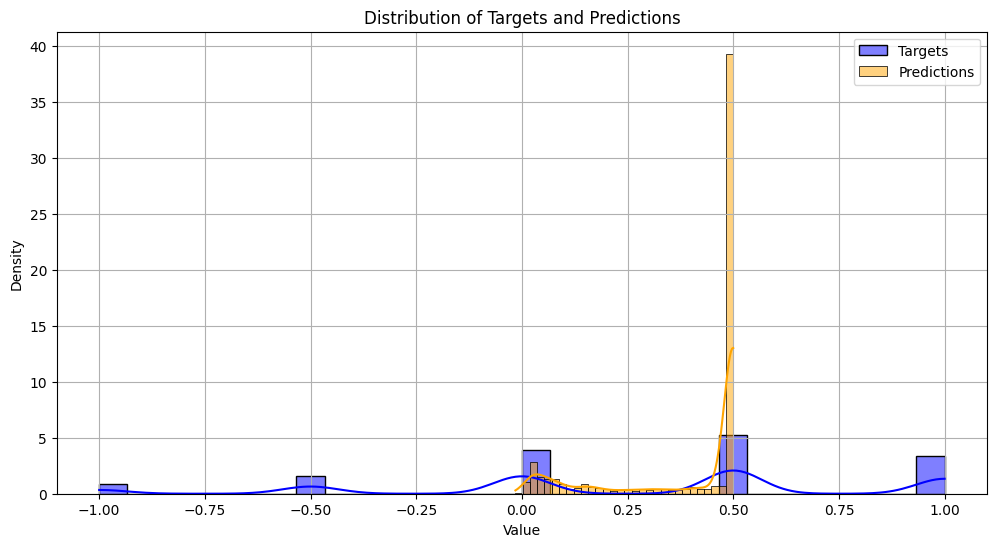

Training Epochs:  40%|████      | 4/10 [01:18<01:58, 19.83s/epoch]

Epoch [4/10], Training Loss: 0.4186, Validation Loss: 0.4164


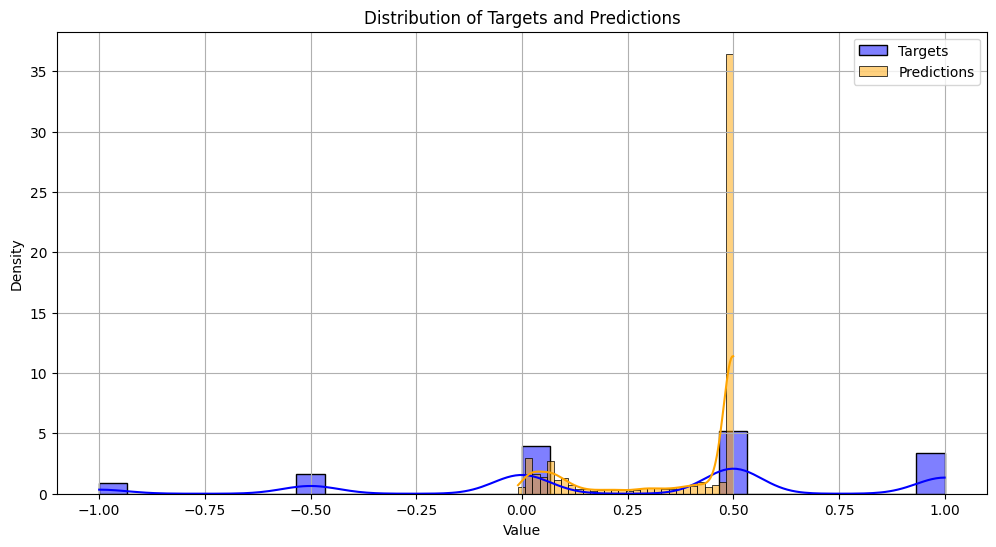

Training Epochs:  50%|█████     | 5/10 [01:36<01:35, 19.12s/epoch]

Epoch [5/10], Training Loss: 0.4183, Validation Loss: 0.4160


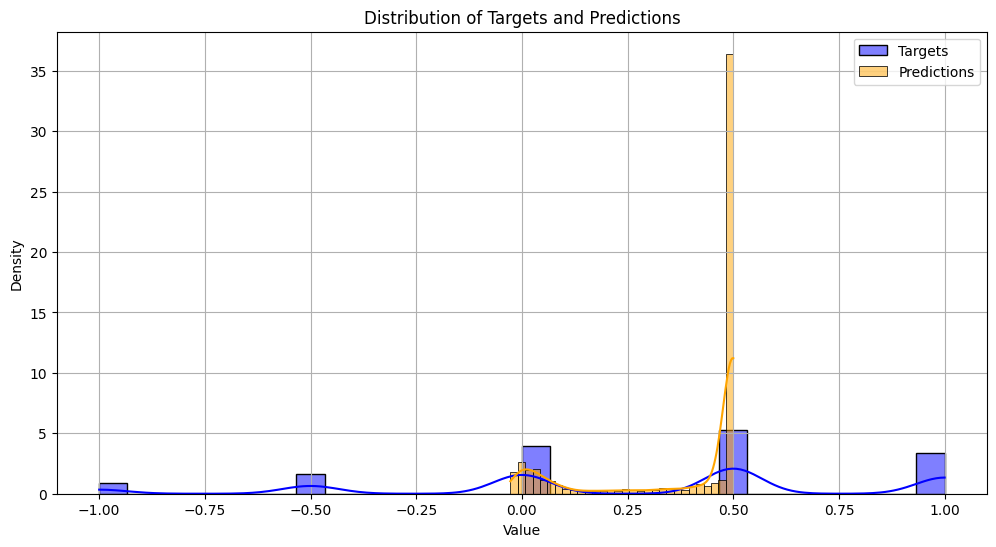

Training Epochs:  60%|██████    | 6/10 [01:56<01:17, 19.32s/epoch]

Epoch [6/10], Training Loss: 0.4180, Validation Loss: 0.4152


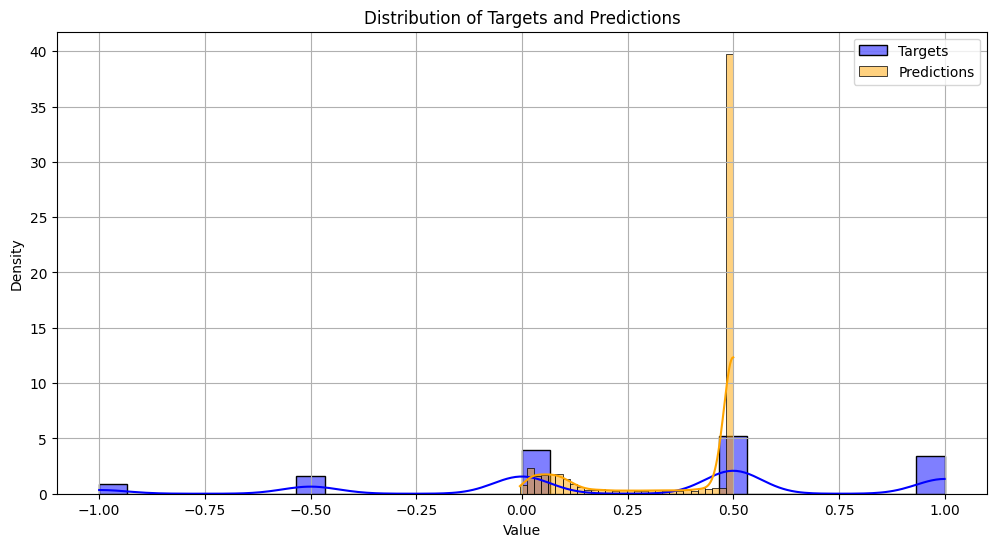

Training Epochs:  70%|███████   | 7/10 [02:16<00:58, 19.56s/epoch]

Epoch [7/10], Training Loss: 0.4178, Validation Loss: 0.4157


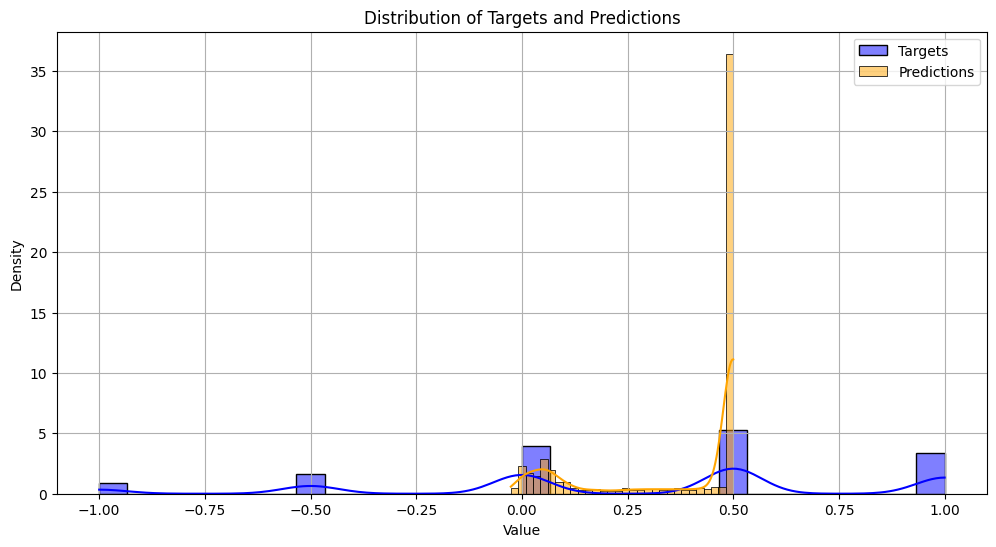

Training Epochs:  80%|████████  | 8/10 [02:34<00:38, 19.06s/epoch]

Epoch [8/10], Training Loss: 0.4179, Validation Loss: 0.4153


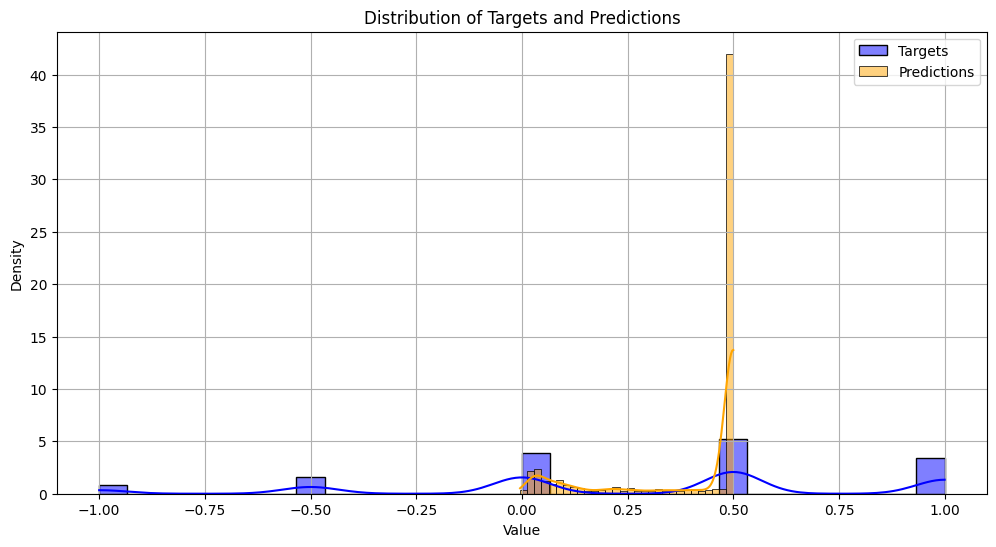

Training Epochs:  90%|█████████ | 9/10 [02:53<00:19, 19.09s/epoch]

Epoch [9/10], Training Loss: 0.4177, Validation Loss: 0.4163


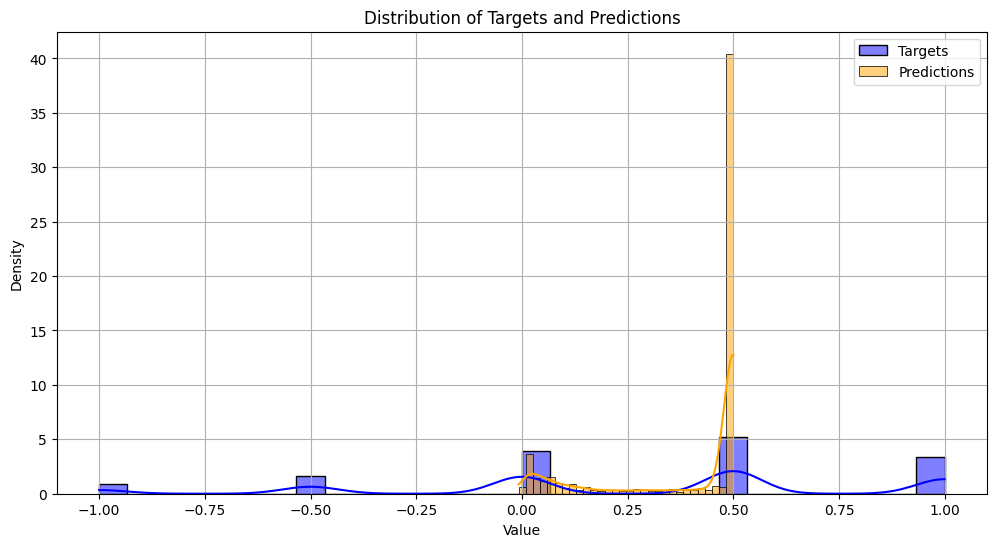

Training Epochs: 100%|██████████| 10/10 [03:12<00:00, 19.27s/epoch]

Epoch [10/10], Training Loss: 0.4177, Validation Loss: 0.4155
Training Complete!


In [95]:
num_epochs = 10

for epoch in tqdm(range(num_epochs), desc="Training Epochs", unit="epoch"):
    model.train()
    running_loss = 0.0

    # Training phase
    for inputs, targets in train_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss (ensure consistent shapes)
        loss = criterion(outputs.squeeze(), targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_dataloader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_predictions = []
    val_targets = []

    with torch.no_grad():
        for inputs, targets in val_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)

            # Store predictions and targets
            val_predictions.extend(outputs.cpu().squeeze().numpy().flatten())
            val_targets.extend(targets.cpu().numpy().flatten())

            # Compute loss (ensure consistent shapes)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)

    # Plot the distributions
    plt.figure(figsize=(12, 6))

    sns.histplot(val_targets, label="Targets", color="blue", kde=True, stat="density", bins=30, alpha=0.5)
    sns.histplot(val_predictions, label="Predictions", color="orange", kde=True, stat="density", bins=30, alpha=0.5)

    plt.title("Distribution of Targets and Predictions")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {avg_train_loss:.4f}, '
          f'Validation Loss: {avg_val_loss:.4f}')

print('Training Complete!')



In [ ]:
 # After all epochs are complete, infer and show predictions for 10 random validation samples
model.eval()  # Make sure the model is in evaluation mode

# Get a random sample from the validation set
random_indices = random.sample(range(len(val_dataloader.dataset)), 10)

print("\nRandom Predictions from the Validation Set:")
for idx in random_indices:
    # Get the corresponding sample
    inputs, target = val_dataloader.dataset[idx]

    # Move to device
    inputs = inputs.to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(inputs.unsqueeze(0))  # Add batch dimension if necessary
        predicted_value = outputs.cpu().numpy()  # Get the prediction as a scalar

    # Print the true label and the prediction
    print(f"True label: {target}, Predicted: {predicted_value}")



Random Predictions from the Validation Set:
True label: -0.5, Predicted: [[0.25324875]]
True label: 1.0, Predicted: [[0.27883822]]
True label: 0.0, Predicted: [[0.27677298]]
True label: 1.0, Predicted: [[0.4361219]]
True label: 0.0, Predicted: [[-0.03896969]]
True label: -0.5, Predicted: [[0.17467475]]
True label: 0.5, Predicted: [[0.26795238]]
True label: 1.0, Predicted: [[0.18313026]]
True label: 0.0, Predicted: [[0.2522735]]
True label: 0.5, Predicted: [[0.13724242]]
